# boundary_conditions_finalize

> Add regularization term to avoid cells collapsing to very small areas, and improve boundary conditions by including two cell rows


In [ ]:
#| default_exp boundary_finalize

In [ ]:
#| hide
from nbdev.showdoc import *
import nbdev

In [ ]:
#| export
from CE_simulation.triangle import *
from CE_simulation.tension import *
from CE_simulation.delaunay import *
from CE_simulation.isogonal import *

In [ ]:
#| export
import os
import sys
import importlib

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.collections import LineCollection

from numpy import sin, cos, tan, pi, sqrt, arccos, arctan, arctan2
from numpy.linalg import norm

from scipy.integrate import solve_ivp
from scipy import ndimage
from scipy import spatial
from scipy import optimize
from scipy import linalg

from tqdm.notebook import tqdm

from copy import deepcopy

from collections import Counter, defaultdict

In [ ]:
#| export

from dataclasses import dataclass
from typing import Union, Dict, List, Tuple, Iterable, Callable
from nptyping import NDArray, Int, Float, Shape

from fastcore.foundation import patch

In [ ]:
#| export

import ipywidgets as widgets
from matplotlib import animation, rc

In [ ]:
#| export

import jax.numpy as jnp
from jax import grad as jgrad
from jax import jit
from jax.tree_util import Partial
from jax.config import config
config.update("jax_enable_x64", True) # 32 bit leads the optimizer to complain about precision loss
#config.update("jax_debug_nans", True)  # useful for debugging, but makes code slower!

In [ ]:
fridtjof_colors = np.array([[0.34398, 0.49112, 0.89936],
[0.97, 0.606, 0.081],
[0.91, 0.318, 0.243],
[0.448, 0.69232, 0.1538],
[0.62168, 0.2798, 0.6914],
[0.09096, 0.6296, 0.85532],
[0.46056, 0.40064, 0.81392],
[0.94, 0.462, 0.162],
[0., 0.7, 0.7],
[0.827051, 0.418034, 0.0243459],
[0.5511749434976025, 0.32014794962639853, 0.8720626412559938],
[0.72694101250947, 0.7196601125010522, 0.],
[0.8680706456216862, 0.2563858708756628, 0.30321559063052295],
[0.2418693812442152, 0.5065044950046278, 0.9902432574930582],
[0.9573908706237908, 0.5369543531189542, 0.11504464931576472]])

## Import select functions from other boundary notebook

In [ ]:
from CE_simulation.boundary_jax import get_triangular_lattice, create_rect_mesh, is_bdry, get_centroid,\
                                       get_bdry, get_conformal_transform, get_areas,\
                                       get_primal_energy_fct_jax, get_E, get_E_jac, polygon_area,\
                                       excitable_dt_act_pass, euler_step, flatten_triangulation, get_flip_edge,\
                                       optimize_cell_shape

## Timestepping wrappers

Needed to re-write them

To - do: In a refactoring step, put the boundary energy back into notebook 3. Probably want to do everything with JAX from now, need to do rewrite.

In [ ]:
#| export
@patch
def optimize_cell_shape(self: HalfEdgeMesh, bdry_list=None,
                        energy_args=None, cell_id_to_modulus=None,
                        tol=1e-3, maxiter=500, verbose=True, bdr_weight=2):
    """Primal optimization. cell_id_to_modulus: function from _vid to relative elastic modulus"""
    x0 = self.dual_vertices_to_initial_cond()
    get_E_arrays, cell_list_vids = self.get_primal_energy_fct_jax(bdry_list)

    if energy_args is None:
        energy_args = {"mod_bulk": 1, "mod_shear": .2,"angle_penalty": 1000, "bdry_penalty": 100,
                       "epsilon_l": 1e-4, "A0": jnp.sqrt(3)/2, "mod_area": 0}
    if cell_id_to_modulus is not None:
        mod_bulk = energy_args["mod_bulk"]*np.vectorize(cell_id_to_modulus)(cell_list_vids)
        mod_shear = energy_args["mod_shear"]*np.vectorize(cell_id_to_modulus)(cell_list_vids)
        mod_area = energy_args["mod_area"]*np.vectorize(cell_id_to_modulus)(cell_list_vids)
    else:
        mod_bulk, mod_shear, mod_area = (energy_args["mod_bulk"], energy_args["mod_shear"],
                                         energy_args["mod_area"])
    
    if bdr_weight != 1:
        is_bdr = np.array([any([fc.is_bdr() for fc in self.vertices[v].get_face_neighbors()])
                          for v in cell_list_vids])
        mod_bulk *= (bdr_weight*is_bdr+(1-is_bdr))
        mod_shear *= (bdr_weight*is_bdr+(1-is_bdr))
        mod_area *= (bdr_weight*is_bdr+(1-is_bdr))

    
    cell_shape_args = (mod_bulk, mod_shear, energy_args["angle_penalty"], energy_args["bdry_penalty"],
                       energy_args["epsilon_l"], energy_args["A0"], energy_args["mod_area"])
    
    sol = optimize.minimize(get_E, x0, jac=get_E_jac, args=get_E_arrays+cell_shape_args,
                             method="CG", tol=tol, options={"maxiter": maxiter})
    if sol["status"] !=0 and verbose:
        print("Cell shape optimization failed", sol["message"])
    new_coord_dict = self.initial_cond_to_dual_vertices(sol["x"])
    for key, val in self.faces.items():
        val.dual_coords = new_coord_dict[key]

## Simulation with boundary conditions and passive & active cells

## create mesh - hexagonal lattice parallel to strain

In [ ]:
## create mesh

np.random.seed(0)
mesh_initial = create_rect_mesh(14, 30, noise=0.1, defects=(0,0), straight_bdry=True) #0.075 False

center = np.mean([v.coords for v in mesh_initial.vertices.values()], axis=0)
mesh_initial.transform_vertices(lambda x: x-center)
mesh_initial.set_centroid()

for v in mesh_initial.vertices.values():
    v.rest_shape = sqrt(3)*np.eye(2)

mesh_initial.transform_vertices(shear_mat(1.15))  #1
mesh_initial.set_rest_lengths()

In [ ]:
## set the boundary conditions and mark the active and passive vertices

passive_ids = []
active_ids = []
bdry_up_ids = []
bdry_down_ids = []

max_y = np.max([val.dual_coords[1] for val in mesh_initial.faces.values()])
w_passive = 5.5
for fc in mesh_initial.faces.values():
    #if fc.is_bdr():  # make a passive edge - let's see if that is necessary
    #    passive_ids.append(fc._fid)
    if np.abs(fc.dual_coords[1]) > (max_y-w_passive):
        passive_ids.append(fc._fid)
    else:
        active_ids.append(fc._fid)

passive_ids = sorted(passive_ids)
active_ids = sorted(active_ids)

# create list of passive cells
passive_cells = [v._vid for v in mesh_initial.vertices.values()
                 if not v.is_bdry() and any([fc._fid in passive_ids for fc in v.get_face_neighbors()])]

max_y_cells = np.max([v.get_centroid()[1] for v in mesh_initial.vertices.values() if not v.is_bdry()])

w_bdry = .2
for v in mesh_initial.vertices.values():
    # check vertex is a full valued cell
    if (v.get_centroid()[1] > (max_y_cells-w_bdry)) and (not v.is_bdry()):
        bdry_up_ids.append(v._vid)
    if (v.get_centroid()[1] < -(max_y_cells-w_bdry)) and (not v.is_bdry()):
        bdry_down_ids.append(v._vid)

In [ ]:
print(max_y_cells)

11.724941148653096


In [ ]:
## create the penalty functions

bdry_y = 12

def up_penalty(x):
    return (x[1]-bdry_y)**2
def down_penalty(x):
    return (x[1]+bdry_y)**2

up_penalty = Partial(jit(up_penalty))
down_penalty = Partial(jit(down_penalty))

bdry_list = ([up_penalty, bdry_up_ids], [down_penalty, bdry_down_ids])

## create mesh - hexagonal orthogonal to strain

Works well looks like!

In [ ]:
## create mesh

np.random.seed(1)
mesh_initial = create_rect_mesh(24, 18, noise=0.1, defects=(0, 0), straight_bdry=False) #0.075 False
#noise = .1, defects = (0,0). (16, 18) (24, 18)

mesh_initial.transform_vertices(rot_mat(pi/2))
center = np.mean([v.coords for v in mesh_initial.vertices.values()], axis=0)
mesh_initial.transform_vertices(lambda x: x-center)
mesh_initial.set_voronoi()

for v in mesh_initial.vertices.values():
    v.rest_shape = sqrt(3)*np.eye(2)

mesh_initial.transform_vertices(shear_mat(1.15))
mesh_initial.set_rest_lengths()

In [ ]:
## set the boundary conditions and mark the active and passive vertices

passive_ids = []
active_ids = []

max_y = np.max([val.dual_coords[1] for val in mesh_initial.faces.values()])
w_passive = 5 # 6
for fc in mesh_initial.faces.values():
    #if fc.is_bdr():  # make a passive edge - let's see if that is necessary
    #    passive_ids.append(fc._fid)
    if np.abs(fc.dual_coords[1]) > (max_y-w_passive):
        passive_ids.append(fc._fid)
    else:
        active_ids.append(fc._fid)

passive_ids = sorted(passive_ids)
active_ids = sorted(active_ids)

# create list of passive cells
passive_cells = [v._vid for v in mesh_initial.vertices.values()
                 if not v.is_bdry() and any([fc._fid in passive_ids for fc in v.get_face_neighbors()])]

max_y_cells = np.max([v.get_centroid()[1] for v in mesh_initial.vertices.values() if not v.is_bdry()])

w_bdry = .4

bdry_up_ids_row = []
bdry_down_ids_row = []

for v in mesh_initial.vertices.values():
    # check vertex is a full valued cell
    if (v.get_centroid()[1] > (max_y_cells-w_bdry)) and (not v.is_bdry()):
        bdry_up_ids_row.append(v._vid)
    if (v.get_centroid()[1] < -(max_y_cells-w_bdry)) and (not v.is_bdry()):
        bdry_down_ids_row.append(v._vid)


In [ ]:
print(max_y_cells)

10.797742805207335


In [ ]:
## create the penalty functions

bdry_y = 11 # 11

def up_penalty_row(x):
    return (x[1]-(bdry_y))**2
def down_penalty_row(x):
    return (x[1]+(bdry_y))**2

up_penalty_row = Partial(jit(up_penalty_row))
down_penalty_row = Partial(jit(down_penalty_row))


bdry_list = ([up_penalty_row, bdry_up_ids_row], [down_penalty_row, bdry_down_ids_row])


### Plot initial condition

In [ ]:
#| notest
%matplotlib inline

In [ ]:
initial_y_dict = {key: np.round((2/np.sqrt(3))*val.get_centroid()[1]+.5, decimals=0) # for parr
                  #key: np.round(val.get_centroid()[1], decimals=1) # for orth
                  for key, val in mesh_initial.vertices.items()
                  if (not key in passive_cells) and (not val.is_bdry())}

initial_y_dict = {key: val for key, val in initial_y_dict.items()}

print(sorted(set(list(initial_y_dict.values()))))

color_norm = lambda x: ((x-min(initial_y_dict.values())) % 10) / 10
cmap = mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=0, vmax=1), cmap=mpl.cm.tab10)  #tab10

alpha = .5
cell_colors = {key: np.array(cmap.to_rgba(color_norm(val)))*np.array([1,1,1,alpha])
               for key, val in initial_y_dict.items()}

[-6.0, -5.0, -4.0, -3.0, -2.0, -1.0, -0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0]


(-11.5, 11.5)

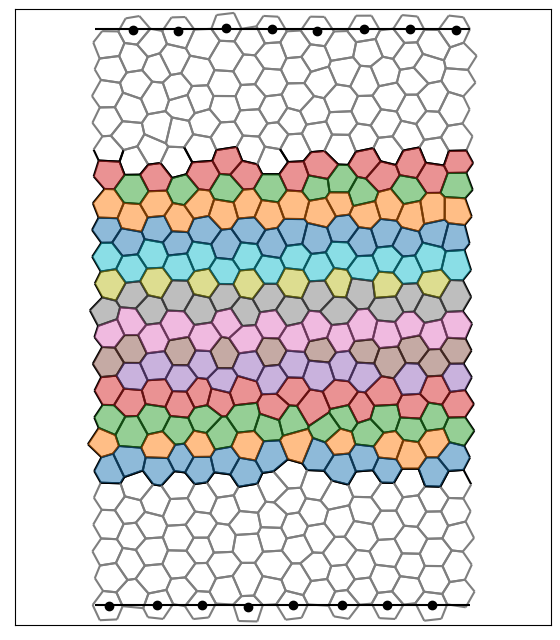

In [ ]:
## plot

passive_edges = flatten([[he._heid for he in mesh_initial.faces[fc].hes] for fc in passive_ids])
edge_colors = {key: "tab:grey" for key in passive_edges}

fig = plt.figure(figsize=(8,8))

mesh_initial.cellplot(edge_colors=edge_colors, cell_colors=cell_colors)
#mesh_initial.triplot()

#mesh_initial.labelplot()

plt.hlines((bdry_y-.25, -bdry_y+.25), (-7, -7), (7, 7), color="k")

#for key in passive_cells: # double check passive cells are correctly identified
#    plt.scatter(*mesh_initial.vertices[key].get_centroid(), c="g")

for key in bdry_up_ids_row+bdry_down_ids_row:
    plt.scatter(*mesh_initial.vertices[key].get_centroid(), c="k")

msh = mesh_initial
_, cell_list_vids = msh.get_primal_energy_fct_jax()
is_bdr = np.array([any([fc.is_bdr() for fc in msh.vertices[v].get_face_neighbors()])
                  for v in cell_list_vids])
             
plt.gca().set_aspect("equal", adjustable="box");
plt.xticks([],[])
plt.yticks([],[])
plt.xlim([-10, 10])
plt.ylim([-bdry_y-.5, bdry_y+.5])

#plt.savefig("plots/initial_cond.pdf")

### To do parameters: minimize the number of helper regularization parameters

`mod_area`, `mod_shear`, `k3`, `tri_reg_A`

Also, do we need `k_rest` ? Probably not if we anyway don't relax the area

Setting all to 0 leads to no net extension, like in Toll RM9 case. Let's check 0 bulk modulus and `mod_area=1`

In [ ]:
## set simulation parameters

# function for active and passive
k = 2
k3 = 0 # .4 #.25 regularization term
 
def params_pattern(fid):
    if fid in passive_ids:
        return {"k": .2, "m": 1}  # lower k
    return {"k": k, "m": 2, "k3": k3}  # m: 2

params_no_pattern = {"k": k, "m": 2, "k3": k3}

k_rest = 0 # 2
def rhs_rest_shape(v):
    """Rest shape relaxation but do not relax area, i.e. trace. Also, only relax passive cells"""
    if v._vid in passive_cells:
        delta = v.rest_shape-v.get_shape_tensor()
        return -k_rest*(delta - np.trace(delta)/2 * np.eye(2))
    else:
        return 0

dt = .01 #  0.02
n_steps = 75 # 90, 75, 150
forbid_reflip = 20

minimal_l = .075 # .075
tol, maxiter = (1e-4, 20000) # .5*1e-4, 

mod_bulk = 1
mod_shear = .5
angle_penalty = 1000
bdry_penalty = 5000

epsilon_l = 1e-3

A0 = jnp.sqrt(3)/2
mod_area = 0

tri_reg_A = .2 # # triangle area regularization

bdr_weight = 2

#cell_id_to_modulus = None 
rel_elastic_modulus = .8 # reduction in elastic modulus in passive cells
cell_id_to_modulus = np.vectorize(lambda x: 1-rel_elastic_modulus*(x in passive_cells))

energy_args = {"mod_bulk": mod_bulk, "mod_shear": mod_shear,
               "angle_penalty": angle_penalty, "bdry_penalty": bdry_penalty, "epsilon_l": epsilon_l,
               "A0": A0, "mod_area": mod_area}

In [ ]:
## for testing purposes - run cell shape optimization, without wrapper, see where the issue lies

x0 = mesh_initial.dual_vertices_to_initial_cond()
get_E_arrays, cell_list_vids = mesh_initial.get_primal_energy_fct_jax() #bdry_list

# create a vector of bulk moduli for active and passive cells
mod_bulk_vec = mod_bulk*cell_id_to_modulus(cell_list_vids)
mod_shear_vec = mod_shear*cell_id_to_modulus(cell_list_vids)

cell_shape_args = (mod_bulk_vec, mod_shear_vec, angle_penalty, bdry_penalty, epsilon_l)

_ = get_E_jac(x0, *(get_E_arrays+cell_shape_args))
_ = get_E(x0, *(get_E_arrays+cell_shape_args))

In [ ]:
%%time
sol = optimize.minimize(get_E, x0, jac=get_E_jac, args=get_E_arrays+cell_shape_args,
                        method="CG", tol=1e-3, options={"maxiter": 5000})  #50000

print(sol["message"], "n_eval: ", sol["nfev"], sol["njev"])
print(sol["fun"] , get_E(x0, *(get_E_arrays+cell_shape_args)) / sol["fun"])

Optimization terminated successfully. n_eval:  1707 1707
0.02965118484732018 151.61690885346604
CPU times: user 588 ms, sys: 13 µs, total: 588 ms
Wall time: 587 ms


In [ ]:
meshes = [deepcopy(mesh_initial)]
times = [0]
last_flipped_edges = [[]] # T1_count = np.cumsum([len(x) for x in last_flipped_edge])

# version where all meshes are saved at each modification step, not each time step
meshes_alt = [deepcopy(meshes[0])] 
times_alt = [0]
last_flipped_edges_alt = [[]]

In [ ]:
## simulation loop

mesh = deepcopy(meshes[-1])
for i in tqdm(range(n_steps)):
    # euler step
    mesh.euler_step(dt=dt, rhs=excitable_dt_act_pass, params=params_pattern, rhs_rest_shape=rhs_rest_shape)
    # flatten triangulation
    mesh.flatten_triangulation(reg_A=tri_reg_A)
    # primal optimization
    mesh.optimize_cell_shape(bdry_list=bdry_list, energy_args=energy_args,
                             cell_id_to_modulus=cell_id_to_modulus,
                             tol=tol, maxiter=maxiter, verbose=True, bdr_weight=bdr_weight)
    # check for intercalation
    flipped = []
    failed_flip = []
    flip_edge = get_flip_edge(mesh, minimal_l=minimal_l,
                              exclude=list(flatten(last_flipped_edges[-forbid_reflip:])))
    while flip_edge is not None:
        try:
            print(f"flip {flip_edge}, tpt {i}")
            he = mesh.hes[flip_edge]
            mesh.flip_edge(flip_edge)
            mesh.reset_rest_passive_flip(he, method="smooth")
            f0, f1 = (he.face, he.twin.face)
            f0.dual_coords, f1.dual_coords = rotate_about_center(np.stack([f0.dual_coords, f1.dual_coords]))
            flipped.append(he._heid)
            mesh.optimize_cell_shape(bdry_list=bdry_list, energy_args=energy_args,
                                     cell_id_to_modulus=cell_id_to_modulus,
                                     tol=tol, maxiter=maxiter, verbose=True)
            exclude = list(flatten(last_flipped_edges[-forbid_reflip:]))+flipped+failed_flip
            flip_edge = get_flip_edge(mesh, minimal_l=minimal_l, exclude=exclude)
            
            last_flipped_edges_alt.append([he._heid])
            meshes_alt.append(deepcopy(mesh))
            times_alt.append(times[-1])
        except ValueError:
            failed_flip.append(flip_edge)
            exclude = list(flatten(last_flipped_edges[-forbid_reflip:]))+flipped+failed_flip
            flip_edge = get_flip_edge(mesh, minimal_l=minimal_l, exclude=exclude)
            continue

    # rescale & reorient triangulation
    mesh.transform_vertices(get_conformal_transform(meshes[-1], mesh))
    # log
    last_flipped_edges.append(flipped)
    meshes.append(deepcopy(mesh))
    times.append(times[-1]+dt)
    
    last_flipped_edges_alt.append([])
    meshes_alt.append(deepcopy(mesh))
    times_alt.append(times[-1]+dt)

last_flipped_edges.append([])
last_flipped_edges_alt.append([])

  0%|          | 0/75 [00:00<?, ?it/s]

flip 774, tpt 0
flip 72, tpt 0
flip 2062, tpt 0
flip 1855, tpt 0
flip 57, tpt 0
flip 877, tpt 1
flip 1597, tpt 1
flip 2341, tpt 1
flip 274, tpt 1
flip 265, tpt 1
flip 1231, tpt 2
flip 312, tpt 2
flip 432, tpt 2
flip 730, tpt 2
flip 396, tpt 3
flip 627, tpt 3
flip 909, tpt 3
flip 252, tpt 3
flip 2034, tpt 3
flip 1920, tpt 4
flip 816, tpt 4
flip 1215, tpt 4
flip 1563, tpt 4
flip 741, tpt 4
flip 2071, tpt 4
flip 660, tpt 4
flip 1570, tpt 4
flip 918, tpt 4
flip 429, tpt 4
flip 244, tpt 4
flip 1317, tpt 5
flip 349, tpt 5
flip 619, tpt 6
flip 937, tpt 6
flip 2080, tpt 6
flip 340, tpt 6
flip 1393, tpt 7
flip 600, tpt 7
flip 1770, tpt 7
flip 1621, tpt 7
flip 1584, tpt 7
flip 880, tpt 8
flip 1582, tpt 8
flip 843, tpt 8
flip 1377, tpt 8
flip 939, tpt 9
flip 1839, tpt 9
flip 813, tpt 9
flip 963, tpt 9
flip 1546, tpt 9
flip 961, tpt 9


KeyboardInterrupt: 

In [ ]:
## run without any of the helpers, except triangle area reg.

In [ ]:
meshes[-1].is_consistent()

True

In [ ]:
# if desired, save the meshes.

overwrite = False

dir_name = "germ_band_medium_m4"


try:
    os.mkdir(f"runs/{dir_name}/")
except FileExistsError:
    if not overwrite:
        raise FileExistsError
    else:
        pass
    
[x.save_mesh(f"runs/{dir_name}/{str(ix).zfill(4)}_mesh.txt") for ix, x in enumerate(meshes)];

### Analyze a simulation

In [ ]:
#| notest
%matplotlib inline

In [ ]:
# calculate the shape tensor energies

energies = [{key: val for key, val in msh.get_shape_energy(mod_bulk=mod_bulk, mod_shear=mod_shear).items()
             if val is not None} for msh in meshes]
angle_penalties = [msh.get_angle_deviation() for msh in meshes]

(0.0, 0.005)

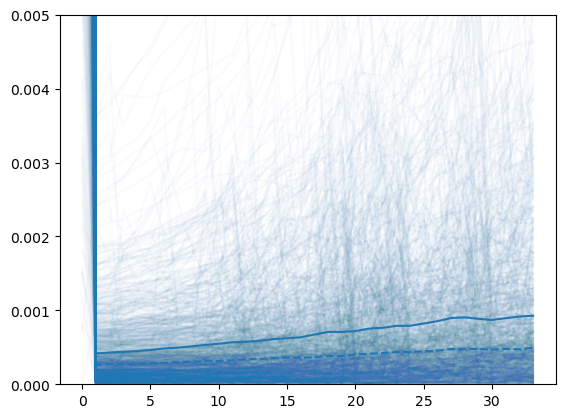

In [ ]:
# time series plot of angle penalties

a_time = np.array([[e[key] for e in angle_penalties] for key in angle_penalties[0].keys()])
plt.plot(a_time.T, color="tab:blue", alpha=.01);
plt.plot(np.mean(a_time, axis=0), color="tab:blue", alpha=1);
plt.plot(np.median(a_time, axis=0), color="tab:blue", alpha=1, ls="--");

plt.ylim([0, 5*1e-3])

(0.0, 1.0)

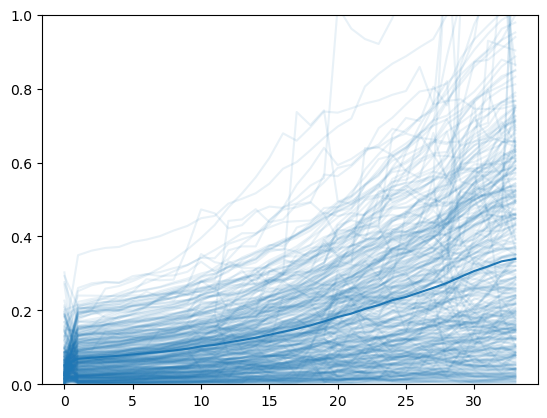

In [ ]:
# time series plot of energies

e_time = np.array([[e[key] for e in energies] for key in energies[0].keys()])
plt.plot(e_time.T, color="tab:blue", alpha=.1);
plt.plot(e_time.mean(axis=0), color="tab:blue", alpha=1);

plt.ylim([0, 10*1e-1])

<matplotlib.collections.PathCollection>

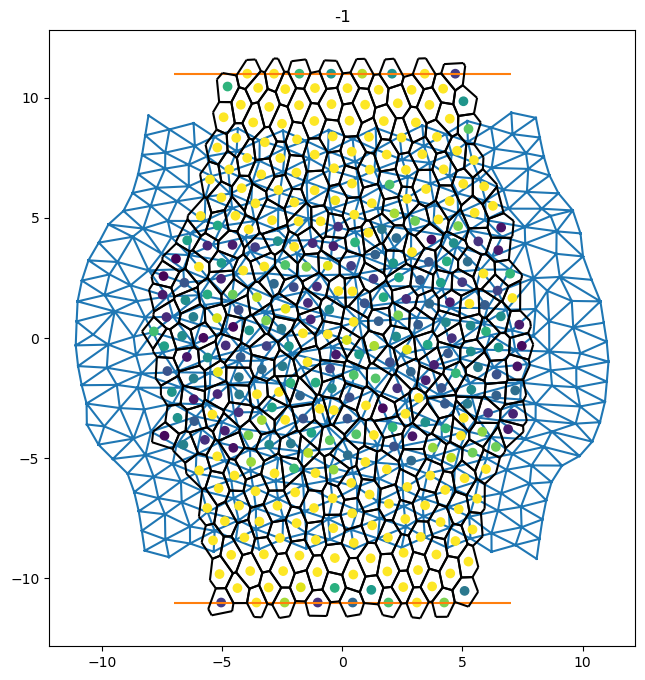

In [ ]:
# spatial plot of shape energies

i = -1

fig = plt.figure(figsize=(8,8))

plt.hlines((bdry_y, -bdry_y), (-7, -7), (7, 7), color="tab:orange")
#plt.ylim([-max_y-.5, max_y+.5])
plt.gca().set_aspect("equal", adjustable="box")
meshes[i].cellplot()
meshes[i].triplot()
#meshes[i].labelplot(face_labels=False, cell_labels=True, vertex_labels=False)

plt.title(i);

# now calculate the energies and centroids
for_scttr = np.stack([np.hstack([np.mean([fc.dual_coords
                                  for fc in meshes[i].vertices[key].get_face_neighbors()], axis=0), [val]])
                     for key, val in energies[i].items()], axis=-1)

plt.scatter(*for_scttr[:2], c=for_scttr[2], vmin=0, vmax=.3)

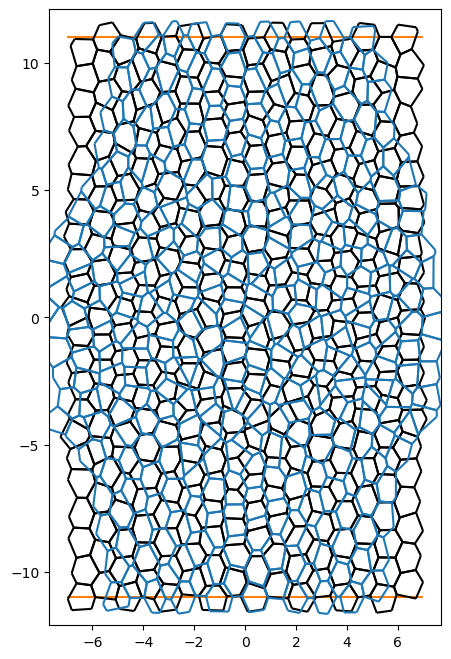

In [ ]:
fig = plt.figure(figsize=(8,8))

plt.hlines((bdry_y, -bdry_y), (-7, -7), (7, 7), color="tab:orange")
plt.gca().set_aspect("equal", adjustable="box")
meshes[1].cellplot()
meshes[-1].cellplot(edge_colors={he: "tab:blue" for he in meshes[-1].hes.keys()})


(0.0, 1.7320508075688772)

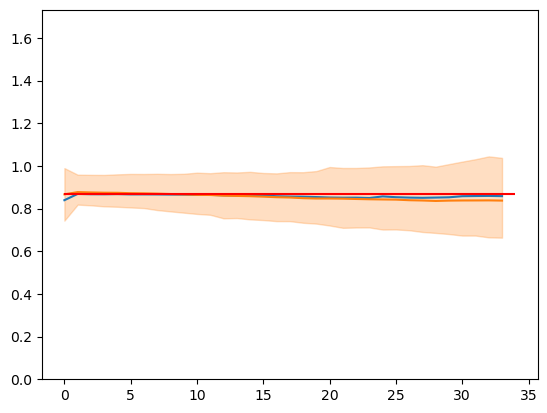

In [ ]:
# create a time-series of areas

areas = np.empty((len(meshes), len(meshes[0].vertices)))
for t, msh in enumerate(meshes):
    for v in msh.vertices.values():
        nghbs = v.get_face_neighbors()
        if (None in nghbs):
            areas[t, v._vid] = np.nan
        else: 
            areas[t, v._vid] = polygon_area(np.stack([fc.dual_coords for fc in nghbs]))
            
areas = areas[:, ~np.isnan(areas).any(axis=0)]

plt.plot(areas[:, 3])
mean = areas.mean(axis=1)

plt.plot(mean)
plt.fill_between(np.arange(areas.shape[0]), np.quantile(areas, .05, axis=1),
                 np.quantile(areas, .95, axis=1), color="tab:orange", alpha=.25)

plt.hlines(sqrt(3)/2, 0, len(meshes), color="r")
plt.ylim([0, sqrt(3)])


Failure at : tpt 90! Make it so that I can see every individual mesh state before it flips

Failure mode: flip of a large number of adjacent edges, all of which were pretty long before flip chain started

<IPython.core.display.Javascript object>


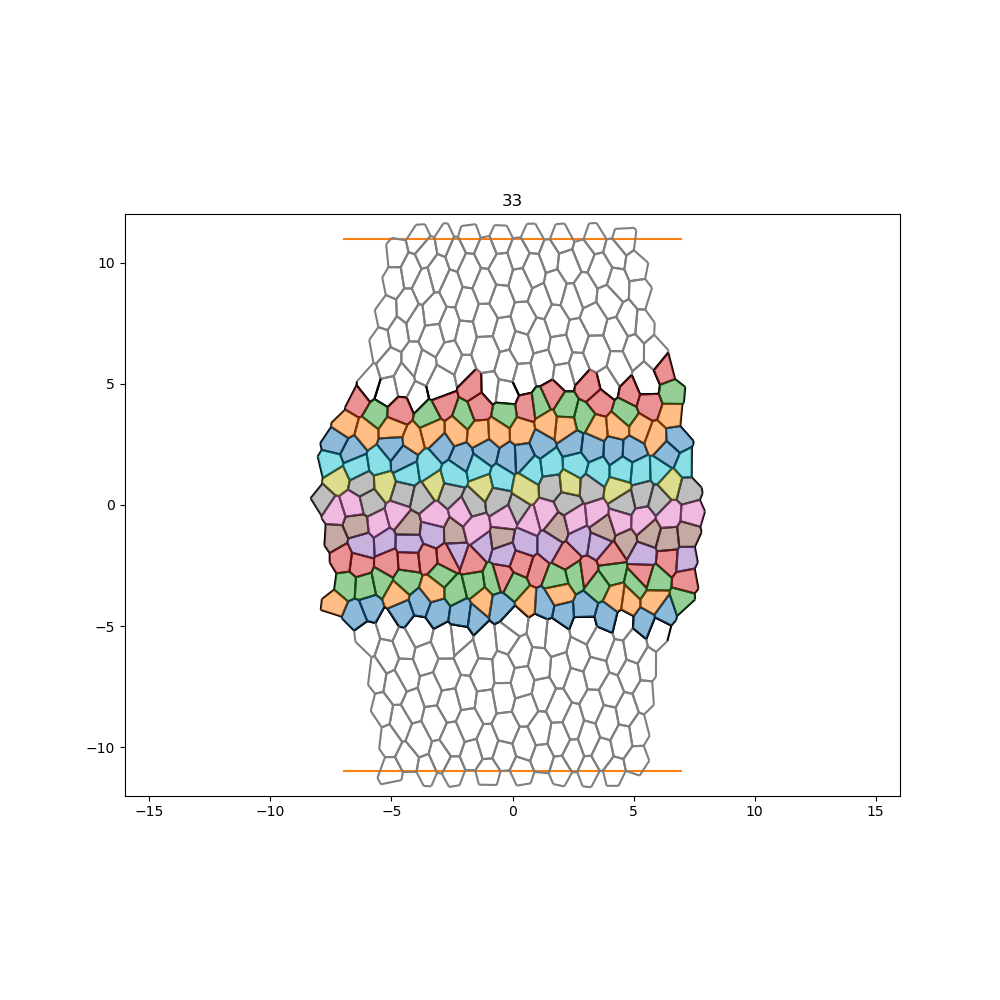

interactive(children=(IntSlider(value=16, description='i', max=33), Output()), _dom_classes=('widget-interact'…

In [ ]:
#| notest

%matplotlib notebook

fig = plt.figure(figsize=(10, 10))

def plot_mesh(i):
    plt.cla()
    plt.hlines((bdry_y, -bdry_y), (-7, -7), (7, 7), color="tab:orange")
    plt.xlim([-16, 16])
    plt.ylim([-bdry_y-1, bdry_y+1])
    #plt.xlim([-2., 2])
    #plt.ylim([0, 4])
    plt.gca().set_aspect("equal", adjustable="box")
    meshes[i].cellplot(edge_colors=edge_colors, cell_colors=cell_colors)
    #meshes[i].labelplot(halfedge_labels=False, vertex_labels=True, face_labels=False)
    #meshes[i].triplot()
    plt.title(i)
    for x in last_flipped_edges[i+1]:
        he = meshes[i].hes[x]
        line = np.stack([he.vertices[0].coords, he.vertices[1].coords])
        #plt.plot(*line.T, c="tab:purple", lw=5)
        line = np.stack([he.face.dual_coords, he.twin.face.dual_coords])
        plt.plot(*line.T, c="r", lw=4)
        
widgets.interact(plot_mesh, i=(0, len(meshes)-1, 1));

# problems start at t=75.

## Angle at the moment of T1 in active cells

It seems that we can generate fairly extremely obtuse triangles. How can this be? Should be eliminated by T1. Why not? Let's quantify the angles at T1s and check.

This can happen in triangle cells where T1s are not possible anymore!

## extension vs time

In [ ]:
centroids = np.stack([[v.get_centroid() for v in msh.vertices.values()
                       if not v._vid in passive_cells and not v.is_bdry()]  for msh in meshes])
moments = np.stack([get_inertia(x) for x in centroids])

In [ ]:
#| notest
%matplotlib inline


(-9.802037260502686, 8.879964934089086, -5.57677532275289, 6.847370435592204)

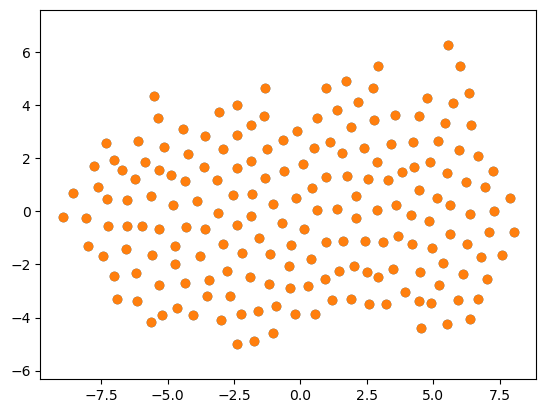

In [ ]:
plt.scatter(*centroids[0].T)
plt.scatter(*centroids[-1].T)

plt.axis("equal")

[<matplotlib.lines.Line2D>]

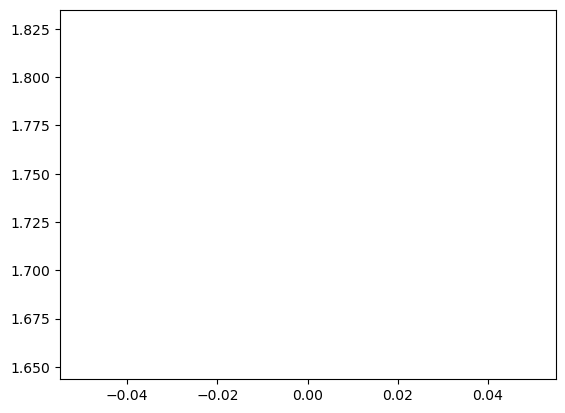

In [ ]:
#plt.plot(moments[:, 0,0])

plt.plot(jnp.sqrt(moments[:, 0,0]/moments[:, 1,1]))

## Plot trajectories of cell centroids, colored along trajectory by time

Say every third or so cell

In [ ]:
trajectories = [[val.get_centroid() for key, val in msh.vertices.items()
                if (not mesh_initial.vertices[key].is_bdry())] for msh in meshes]

trajectories = np.stack(trajectories).transpose((1,0,2))

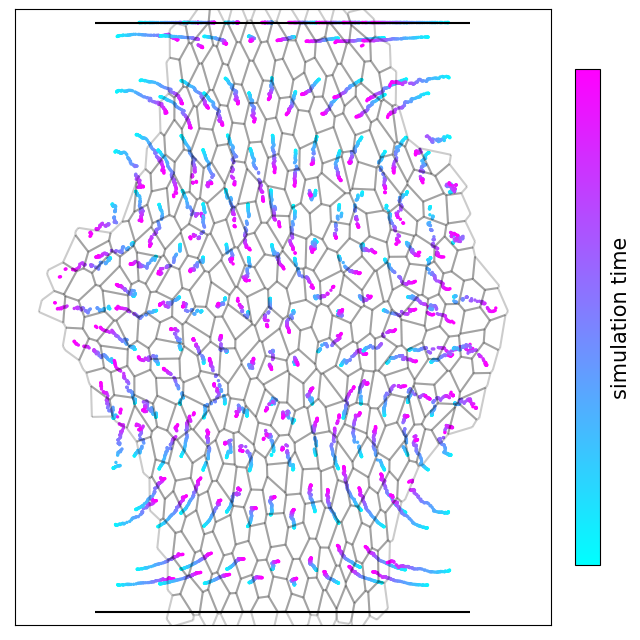

In [ ]:
fig = plt.figure(figsize=(8,8))

t = np.arange(trajectories.shape[1])

stop = -1

for traj in trajectories[::2]:
    plt.scatter(*traj[1:stop].T, s=2, c=t[1:stop], cmap="cool")

cb = plt.colorbar(fraction=0.04, pad=0.04)
cb.set_ticks([])
cb.set_label(label='simulation time', fontsize=15)

meshes[stop].cellplot(alpha=.2)

plt.xticks([],[])
plt.yticks([],[])

plt.hlines((bdry_y, -bdry_y), (-7, -7), (7, 7), color="black", label="slip wall")
plt.xlim([-10, 10])
plt.ylim([-bdry_y-.5, bdry_y+.5])
plt.gca().set_aspect("equal", adjustable="box")

#plt.savefig("plots/trajectories_v2.pdf")

In [ ]:
#| notest
def plot_mesh(i):
    plt.cla()
    plt.hlines((bdry_y, -bdry_y), (-7, -7), (7, 7), color="tab:orange")
    plt.xlim([-2.5, 2.5])
    plt.ylim([-1, 4])
    #plt.xlim([-2., 2])
    #plt.ylim([0, 4])
    plt.gca().set_aspect("equal", adjustable="box")
    meshes[i].cellplot(edge_colors=edge_colors, cell_colors=cell_colors)
    plt.xticks([],[])
    plt.yticks([],[])

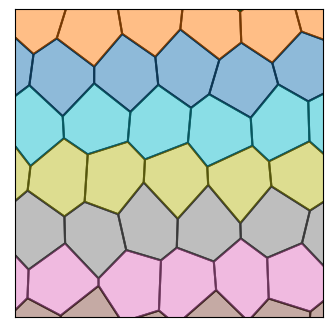

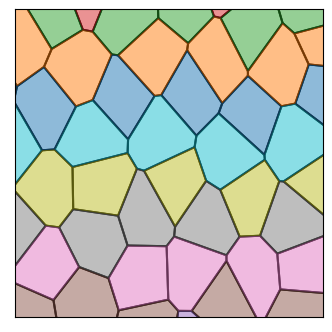

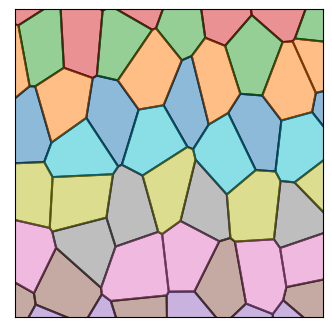

In [ ]:
fig = plt.figure(figsize=(4, 4))
plot_mesh(1)
plt.savefig("plots/snapshot_initial.pdf")
plt.show()

fig = plt.figure(figsize=(4, 4))
plot_mesh(25)
plt.savefig("plots/snapshot_intermediate.pdf")
plt.show()

fig = plt.figure(figsize=(4, 4))
plot_mesh(50)
plt.savefig("plots/snapshot_final.pdf")
plt.show()

## Compute triangle order parameter in active cells

Histogram based approach

In [ ]:
def get_shape_order_param(triangle):
    alpha, beta, gamma = triangle
    x = sqrt(3)*sin(alpha)*sin(alpha+2*beta)
    y = (cos(alpha)*cos(alpha+2*beta) - cos(2*alpha))
    psi = np.arctan2(x, y) + pi

    Psi = 6+2*(cos(4*triangle)-cos(2*triangle) - cos(2*(triangle-np.roll(triangle, 1, axis=0)))).sum(axis=0)
    Psi /= (3-cos(2*triangle).sum(axis=0))**2
    Psi = np.sqrt(Psi)
    
    psi_tilde = pi - np.abs((3*psi) % (2*pi) - pi)
    
    return np.array([psi_tilde, Psi])

In [ ]:
def get_vertex_angles(msh, method="real", exclude=None):
    exclude = [exclude] if exclude is None else exclude
    if method == "dual":
        lengths = [np.array([np.linalg.norm(x.vertices[1].coords-x.vertices[0].coords) for x in fc.hes])
                   for fc in msh.faces.values() if (not (fc._fid in exclude))]
        angles = np.array([sides_angles(x) for x in lengths])
    if method == "real":
        angles = []
        for fc in msh.faces.values():
            if (not (fc._fid in exclude)) and (not fc.is_bdr()):
                vecs = np.stack([he.twin.face.dual_coords-fc.dual_coords for he in fc.hes])
                angle = [np.pi-vectors_angle(x, y) for x,y in zip(vecs, np.roll(vecs, 1, axis=0))]
                angles.append(np.array(angle))
        angles = np.array(angles)
    
    return angles

In [ ]:
def scatter_hist(x, y, bins, ax, ax_histx, ax_histy, ticks_off=True, vmin=None, vmax=None):
    # no labels
    ax_histx.tick_params(axis="x", labelbottom=False)
    ax_histy.tick_params(axis="y", labelleft=False)

    if ticks_off:
        ax_histx.set_yticks([],[])
        ax_histy.set_xticks([],[])

    # the scatter plot:
    ax.hist2d(x, y, bins=bins, density=True, cmap="magma", vmin=vmin, vmax=vmax)

    ax_histx.hist(x, bins=bins[0], alpha=.5, density=True)
    ax_histy.hist(y, bins=bins[1], orientation='horizontal', alpha=.5, density=True)
    
def eqspace(x0, x1, dx):
    return np.linspace(x0, x1, np.round(abs(x1-x0)/dx).astype(int))

In [ ]:
angle_series = [get_vertex_angles(msh, exclude=passive_ids, method="real") for msh in meshes]

dsf_series = [get_shape_order_param(x.T) for x in angle_series]

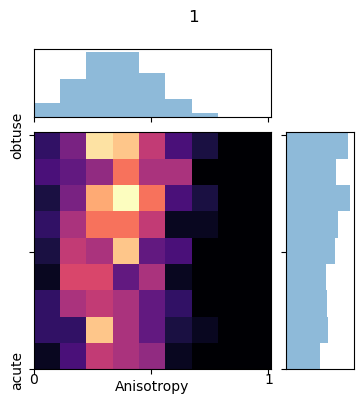

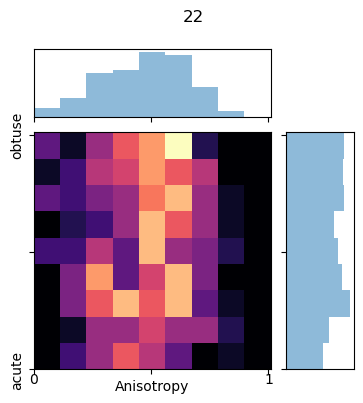

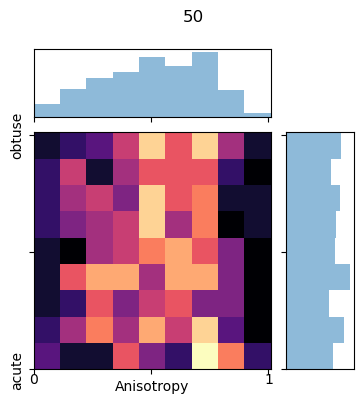

In [ ]:
for t in [1, 22, 50]:

    fig = plt.figure(figsize=(4,4))
    fig.suptitle(f'{t}', y=1.)

    gs = fig.add_gridspec(2, 2,  width_ratios=(7, 2), height_ratios=(2, 7),
                          left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.1, hspace=0.1)
    ax = fig.add_subplot(gs[1, 0])
    ax_histx, ax_histy = (fig.add_subplot(gs[0, 0], sharex=ax), fig.add_subplot(gs[1, 1], sharey=ax))

    bins = [eqspace(0, 1+.01, .1), eqspace(0, 1+.01, .1)]
    scatter_hist(dsf_series[t][1], dsf_series[t][0]/np.pi, bins, ax, ax_histx, ax_histy)
    
    ax.set_ylabel("", labelpad=-5)
    ax.set_xlabel("Anisotropy", labelpad=-5)
    ax.set_xticks([0, 1/2, 1], [0, "", 1], rotation=0, va='center') 
    ax.set_yticks([0, 1/2, 1], ["acute", "", r"obtuse"], rotation=90, va='center')
    #ax.set_aspect('equal', adjustable='box')
    plt.show()

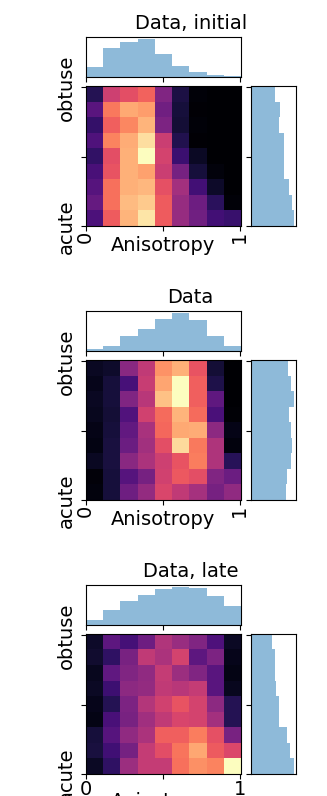

### Create and save an animation

In [ ]:
#| notest
%matplotlib inline

# Save simulation as HTML5 animation

# create the figure and axes objects
fig = plt.figure(facecolor="white", dpi=300)
nframes, frame_dt = n_steps, 500  # Delay between frames in milliseconds

def animate_meshes(n):
    n = n+1
    plt.cla()
    plt.hlines((bdry_y, -bdry_y), (-7, -7), (7, 7), color="tab:orange")
    plt.xlim([-11, 11])
    plt.ylim([-bdry_y-.5, bdry_y+.5])
    plt.gca().set_aspect("equal", adjustable="box")
    plt.title('')
    meshes[n].cellplot(edge_colors=edge_colors, cell_colors=cell_colors)
    #meshes[n].triplot()
    for x in last_flipped_edges[n+1]:
        he = meshes[n].hes[x]
        line = np.stack([he.vertices[0].coords, he.vertices[1].coords])
        #plt.plot(*line.T, c="tab:purple", lw=2)
        line = np.stack([he.face.dual_coords, he.twin.face.dual_coords])
        plt.plot(*line.T, c="r", lw=2)
    if n == nframes-1:
        plt.close()

# run the animation
anim = animation.FuncAnimation(fig, animate_meshes, frames=71, interval=frame_dt, repeat=False)
anim.save('plots/germ_band_medium_parr.mp4', fps=4,)
# maybe best to start from 1